In [1]:
# Dataset & file handling
from ucimlrepo import fetch_ucirepo
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Experiment tracking
import mlflow
import mlflow.sklearn

# ML utilities
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer



In [2]:
# Create data directory
os.makedirs("data", exist_ok=True)

# Fetch Heart Disease dataset from UCI
heart_disease = fetch_ucirepo(id=45)

# Extract features and target
X = heart_disease.data.features
y = heart_disease.data.targets

# Convert target to 1D
y = y.iloc[:, 0]

# Combine features and target
df = pd.concat([X, y], axis=1)

# Rename target column
df.rename(columns={y.name: "target"}, inplace=True)

# Convert to binary classification
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# Save dataset
df.to_csv("data/heart.csv", index=False)

print("Heart Disease dataset downloaded and saved successfully")


Heart Disease dataset downloaded and saved successfully


In [3]:
# Load saved dataset
df = pd.read_csv("data/heart.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [4]:
# Shape, schema and missing values
df.shape
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

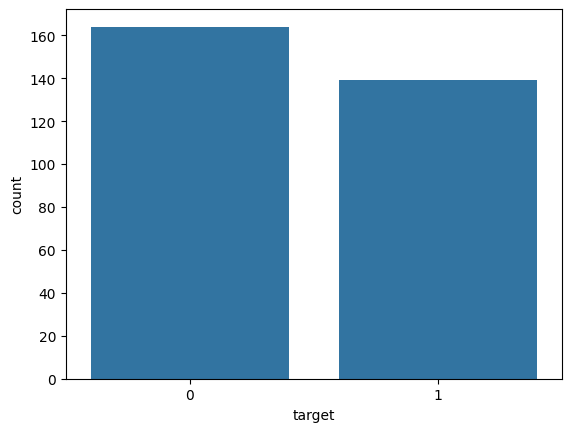

In [5]:
# Class balance
sns.countplot(x="target", data=df)
plt.show()


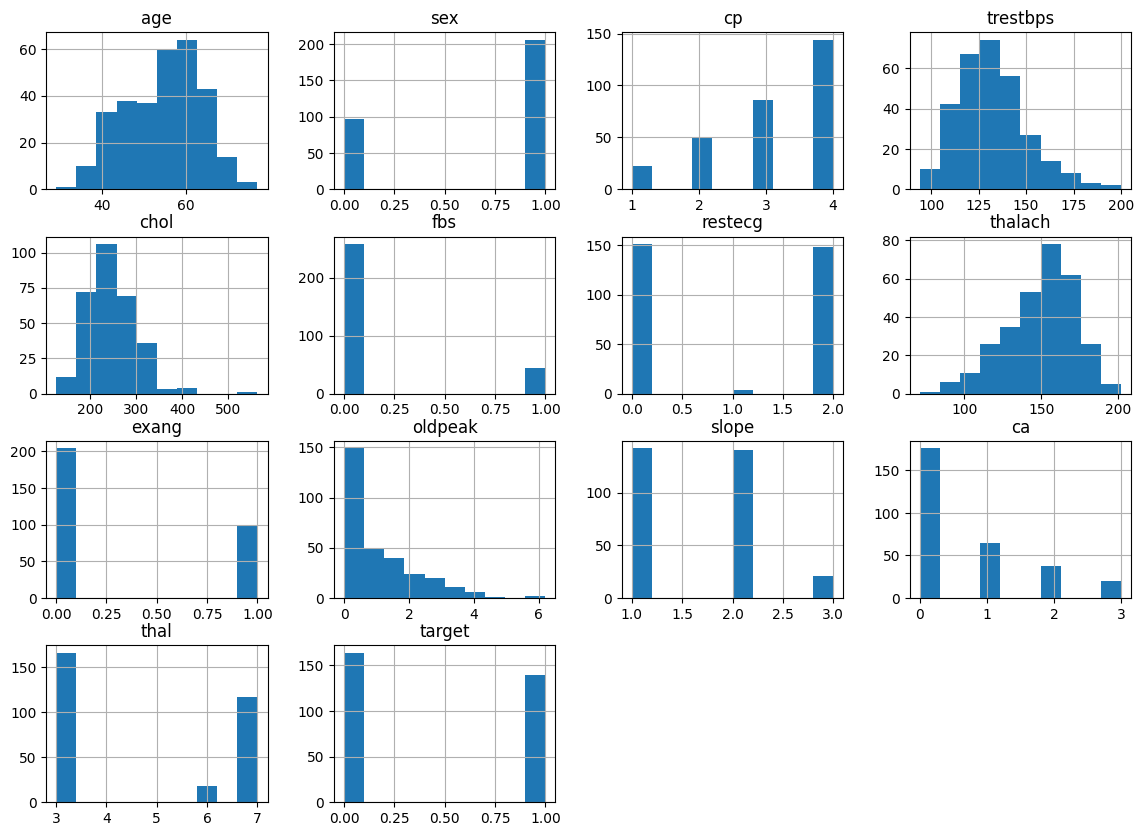

In [6]:
# Distribution of numerical features
df.hist(figsize=(14, 10))
plt.show()


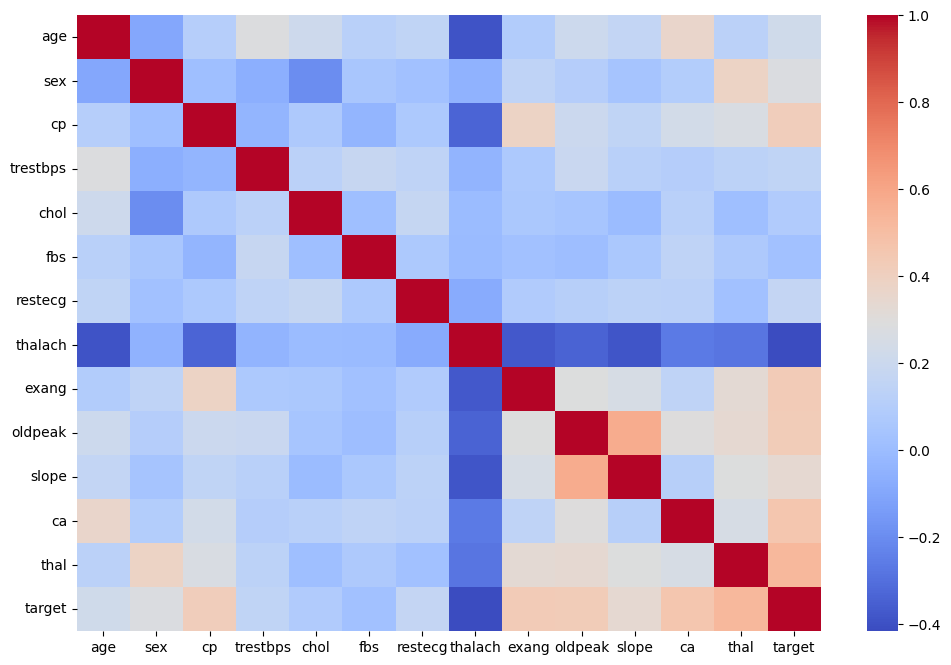

In [7]:
# Feature correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.show()


In [8]:
# Split features and label
X = df.drop("target", axis=1)
y = df["target"]


In [9]:
# Scale numerical features
numeric_features = X.columns.tolist()

# Handle missing values + scale features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ]
)



In [10]:
# Set MLflow experiment
mlflow.set_experiment("Heart Disease Prediction")


2025/12/28 12:51:35 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/28 12:51:35 INFO mlflow.store.db.utils: Updating database tables
2025/12/28 12:51:35 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/28 12:51:35 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/28 12:51:35 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/28 12:51:35 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:c:/Users/sonaa/OneDrive/Documents/ML OPS/mlops_code/mlruns/1', creation_time=1766903558773, experiment_id='1', last_update_time=1766903558773, lifecycle_stage='active', name='Heart Disease Prediction', tags={}>

In [11]:
# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

# Cross-validation
lr_scores = cross_val_score(
    lr_pipeline, X, y, cv=5, scoring="roc_auc"
)

lr_scores.mean()


np.float64(0.9011639209555877)

In [12]:
# Log Logistic Regression run
with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_metric("roc_auc", lr_scores.mean())
    lr_pipeline.fit(X, y)
    mlflow.sklearn.log_model(lr_pipeline, "model")


2025/12/28 12:51:41 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/12/28 12:51:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

In [13]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

# Cross-validation
rf_scores = cross_val_score(
    rf_pipeline, X, y, cv=5, scoring="roc_auc"
)

rf_scores.mean()


np.float64(0.9000519831248998)

In [14]:
# Log Random Forest run
with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_metric("roc_auc", rf_scores.mean())
    rf_pipeline.fit(X, y)
    mlflow.sklearn.log_model(rf_pipeline, "model")


2025/12/28 12:51:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [15]:
# Save best model locally
os.makedirs("models", exist_ok=True)

mlflow.sklearn.save_model(
    sk_model=rf_pipeline,
    path="models/final_model"
)


In [16]:
print("EDA, model training, and MLflow tracking completed")


EDA, model training, and MLflow tracking completed
